In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np
import pandas as pd

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# ANÁLISIS EXPLORATORIO SOBRE EL CONJUNTO DE DATOS

In [2]:
animales = "cats", "dogs"

# Directorio de imágenes
TRAIN_DIR = Path('./imagenes_tp3_cv/training_set/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set/test_set')

## Estructura y tipo de las imagenes

Nombre imagen: dog.3062.jpg
Dimensiones de la imagen:
(399, 268, 3)


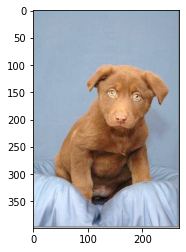

Nombre imagen: cat.3280.jpg
Dimensiones de la imagen:
(375, 499, 3)


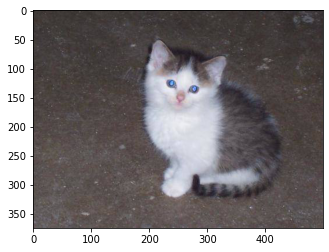

Nombre imagen: dog.3126.jpg
Dimensiones de la imagen:
(499, 491, 3)


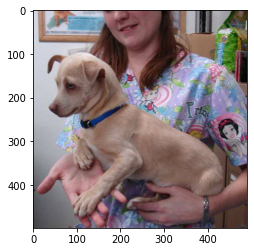

Nombre imagen: cat.501.jpg
Dimensiones de la imagen:
(463, 500, 3)


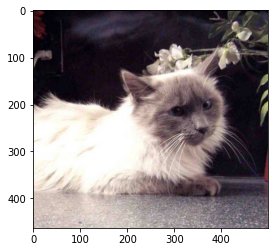

Nombre imagen: dog.1086.jpg
Dimensiones de la imagen:
(333, 499, 3)


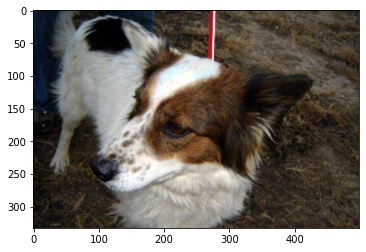

Nombre imagen: cat.2676.jpg
Dimensiones de la imagen:
(498, 499, 3)


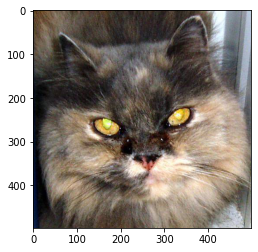

In [3]:
from skimage import io
from random import randint

for x in range(3):
    
    nro_imagen_dog = randint(0,4000)
    nro_imagen_cat = randint(0,4000)
    image_dog=io.imread("./imagenes_tp3_cv/training_set/training_set/dogs/dog.{}.jpg".format(nro_imagen_dog))
    image_cat=io.imread("./imagenes_tp3_cv/training_set/training_set/cats/cat.{}.jpg".format(nro_imagen_cat))

    print("Nombre imagen: dog."+ str(nro_imagen_dog) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_dog.shape)
    plt.imshow(image_dog)
    plt.show()
    
    print("Nombre imagen: cat."+ str(nro_imagen_cat) + ".jpg")
    print("Dimensiones de la imagen:")
    print(image_cat.shape)
    plt.imshow(image_cat)
    
    plt.show()

## Volumetría de datos

In [4]:
train = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=animales,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=47,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [5]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=animales,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=47,
)

Found 2023 files belonging to 2 classes.


In [6]:
def sample_images(dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(animales[np.argmax(labels[i])])
            plt.axis("off")

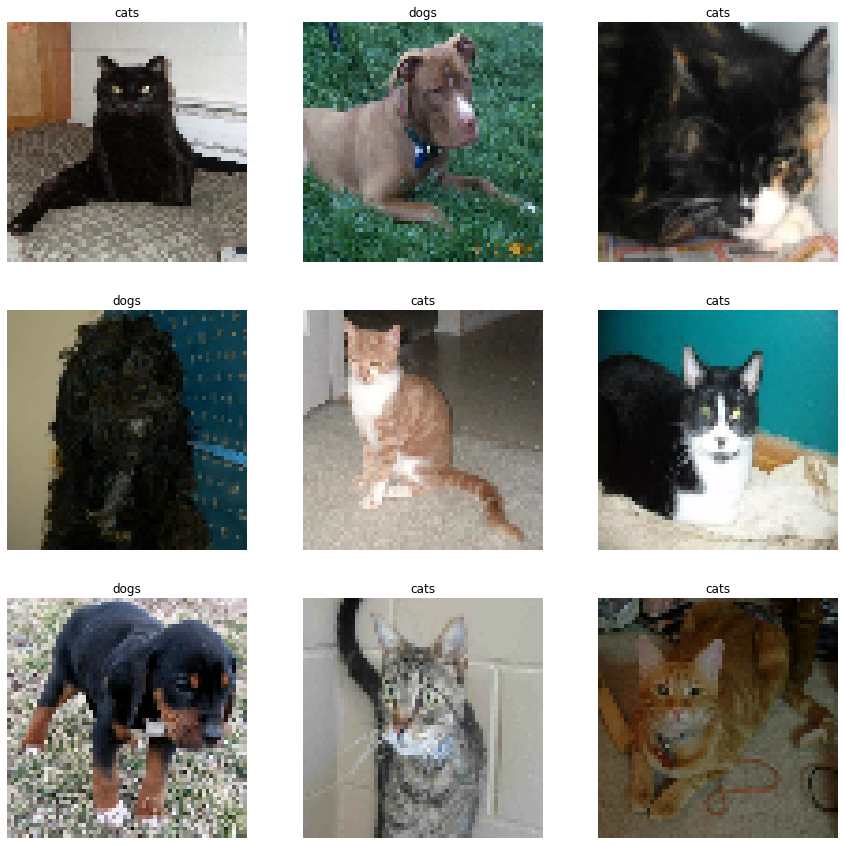

In [7]:
sample_images(train)

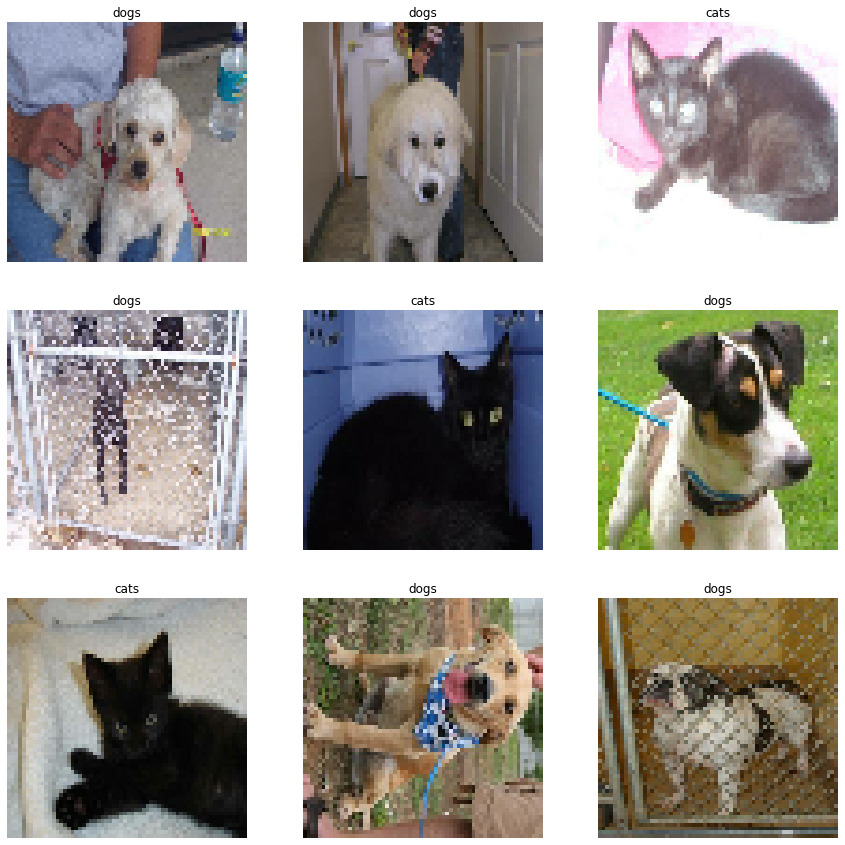

In [8]:
sample_images(test)

## Distribución de la variable a predecir

# MACHINE LEARNING

## Funciones útiles

In [9]:
# Función para predecir

from IPython.display import Image, display

def show_and_predict(model,image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", animales[np.argmax(predictions)])
    print("Prediction detail:", predictions)

In [10]:
# Función que dibuja la matriz de confusión
def matriz(model):
    
    datasets = (
        ("train", train),
        ("test", test),   
    )

    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
        # concatenamos todo
        batches_predictions = []
        batches_labels =  []

        for batch_images, batch_labels in dataset:
            # super importante: usamos argmax para convertir cosas de este formato:
            # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
            # a este formato (donde tenemos el índice de la clase que tiene número más alto):
            # [1, 0, 0, 2]
            batches_predictions.append(np.argmax(model.predict(batch_images), axis=-1))
            batches_labels.append(np.argmax(batch_labels, axis=-1))

        predictions = np.concatenate(batches_predictions)
        labels = np.concatenate(batches_labels)

        print('accuracy', accuracy_score(labels, predictions))

        # graficamos la confussion matrix
        plt.figure(figsize=(3, 4))

        plt.xticks([0, 1], animales, rotation=45)
        plt.yticks([0, 1], animales)
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.imshow(
            confusion_matrix(labels, predictions), 
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()

In [11]:
# Función que dibuja las curvas
def curvas(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Accuracy over train epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

## Modelos

### MLP 1

In [12]:
model_mlp_1 = Sequential([
    
    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Flatten(),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_mlp_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [13]:
model_mlp_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 64, 64, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                122890    
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

In [14]:
history_mlp_1 = model_mlp_1.fit(
    train,
    epochs=5,
    batch_size=128, # Ajusta los pesos cada x imagenes
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 28s 104ms/step - loss: 0.8207 - accuracy: 0.5018 - val_loss: 0.6942 - val_accuracy: 0.5002
Epoch 2/5
251/251 [==============================] - 26s 101ms/step - loss: 0.7381 - accuracy: 0.4934 - val_loss: 0.6947 - val_accuracy: 0.5002
Epoch 3/5
251/251 [==============================] - 26s 101ms/step - loss: 0.7160 - accuracy: 0.4920 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 4/5
251/251 [==============================] - 25s 97ms/step - loss: 0.7038 - accuracy: 0.5013 - val_loss: 0.6939 - val_accuracy: 0.5002
Epoch 5/5
251/251 [==============================] - 27s 106ms/step - loss: 0.6998 - accuracy: 0.4973 - val_loss: 0.6939 - val_accuracy: 0.5002


######################### train #########################
accuracy 0.5003123048094941


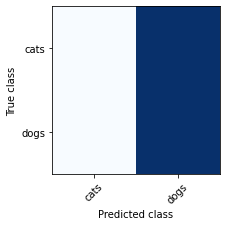

######################### test #########################
accuracy 0.5002471576866041


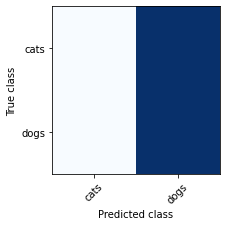

In [15]:
matriz(model_mlp_1)

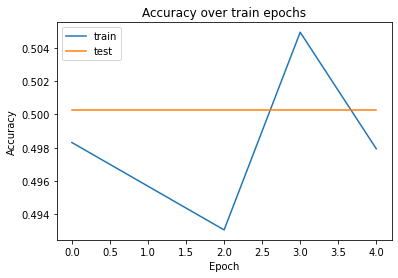

In [16]:
curvas(history_mlp_1)

### CONVOLUCIONAL 1

In [17]:
model_cnn1 = Sequential([

    Rescaling(1/255, input_shape=(64, 64, 3)), # normalizar las entradas de los datasets

    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    Flatten(),
    # salida de 1568
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(animales), activation='softmax'),
    # salida de 2
])

model_cnn1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [18]:
model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 61, 8)         392       
_________________________________________________________________
dropout_2 (Dropout)          (None, 61, 61, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 8)         1032      
_________________________________________________________________
dropout_3 (Dropout)          (None, 58, 58, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)             

In [20]:
history_cnn1 = model_cnn1.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 105s 416ms/step - loss: 0.5677 - accuracy: 0.7068 - val_loss: 0.5559 - val_accuracy: 0.7168
Epoch 2/5
251/251 [==============================] - 90s 357ms/step - loss: 0.5505 - accuracy: 0.7262 - val_loss: 0.5527 - val_accuracy: 0.7153
Epoch 3/5
251/251 [==============================] - 91s 360ms/step - loss: 0.5295 - accuracy: 0.7453 - val_loss: 0.5552 - val_accuracy: 0.7177
Epoch 4/5
251/251 [==============================] - 92s 367ms/step - loss: 0.5094 - accuracy: 0.7502 - val_loss: 0.5465 - val_accuracy: 0.7232
Epoch 5/5
251/251 [==============================] - 94s 373ms/step - loss: 0.5049 - accuracy: 0.7646 - val_loss: 0.5599 - val_accuracy: 0.7168


######################### train #########################
accuracy 0.752529668956902


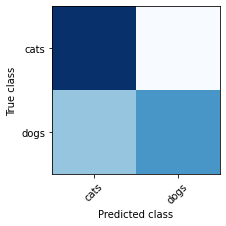

######################### test #########################
accuracy 0.7167572911517548


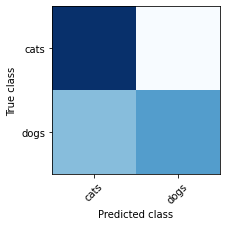

In [21]:
matriz(model_cnn1)

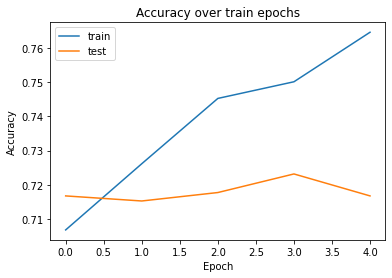

In [22]:
curvas(history_cnn1)

### Red Convolucional elegida: Ejemplos

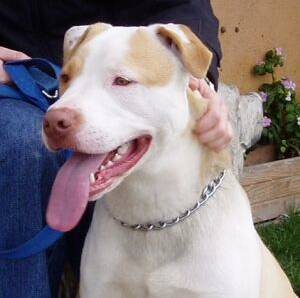

Prediction: dogs
Prediction detail: [[0.1985169 0.8014831]]


In [23]:
show_and_predict(model_cnn1,"/home/migue/Escritorio/MachineLearning/imagenes_tp3_cv/test_set/test_set/dogs/dog.4089.jpg")